In [1]:
import numpy as np
import pickle, os
import matplotlib.pyplot as plt
from hyperparameters import *
from sliding_window import *
from clustering import *
from plotting import *
# from sliding_window_per_network import *
from scipy.stats import ttest_rel, ttest_ind
from stats import *

import warnings, numpy as np
warnings.filterwarnings("ignore", category=RuntimeWarning)
np.seterr(all="ignore");

In [2]:
TR              = 0.80      # seconds, 800 ms
ROIs            = 216       # number of ROIs
win_len         = 56        # 30–50 TR (≈28–40 s, with TR=0.8s)
step            = 25        # = 1 otherwise: the higher the less autocorrelation
use_gaussian    = True      # False for rectangular sliding window
sigma           = None      # if None, sigma = win_len/3
fisher_z        = True      # False
vectorize       = True      # False
zscore          = True      # False
work_with_nets  = False     # True

In [3]:
# Identify Networks
roi_to_network, roi_net_masks, net_mask_names = load_roi_net_from_lut(
    yeo_atlas_path="atlas/Schaefer2018_200Parcels_17Networks_order_info.txt", # _pCun
    tian_atlas_path="atlas/Tian_Subcortex_S1_3T_label.txt",
    combine_networks=True)

# print("Networks:", roi_to_network)
print(f'Example: "Default Mode Network (DMN)" index: {net_mask_names["Default"]}')

Networks: ['AMY' 'CAU' 'Cont' 'Default' 'DorsAttn' 'GP' 'HIP' 'Limbic' 'NAc' 'PUT'
 'SalVentAttn' 'SomMot' 'TempPar' 'VisCent' 'VisPeri' 'aTH' 'pTH'], 17 unique networks.
Example: "Default Mode Network (DMN)" index: 3


### ToDo:
1. Usa `Baseline` invece di SHAM/REAL PRE;
2. Approfondisci in letteratura;
3. Metastability analysis: che cos'è e approfondisci paper;
4. Includi `17Networks_LH_ContC_pCun_1`e `17Networks_LH_ContC_pCun_2`(LH e RH) nel DMN direttamente.

In [4]:
which_networks = [
    "Default",
    # "DorsAttn"
    "HIP"
]

In [5]:
# 1) Load timeseries
Data_folder = 'Data/'
BASELINE    = np.load(f'{Data_folder}/BASELINE_timeseries.npy') 
SHAM_PRE    = np.load(f'{Data_folder}/SHAM_timeseries_PRE.npy')
SHAM_POST   = np.load(f'{Data_folder}/SHAM_timeseries_POST.npy')
REAL_PRE    = np.load(f'{Data_folder}/non_SHAM_timeseries_PRE.npy')
REAL_POST   = np.load(f'{Data_folder}/non_SHAM_timeseries_POST.npy')

TimePoints = min(BASELINE.shape[1],SHAM_PRE.shape[1], SHAM_POST.shape[1], REAL_PRE.shape[1], REAL_POST.shape[1])

# 2) Optionally, select only specific networks
if work_with_nets and which_networks is not None:
    combined_mask = np.zeros(ROIs, dtype=bool)
    masks = [roi_net_masks[net_mask_names[n]] for n in which_networks]
    if len(masks) > 1:
        for mask in masks:
            combined_mask |= mask 
    else:
        combined_mask = masks[0]
else:
    combined_mask = np.ones(ROIs, dtype=bool)
    
BASELINE    = BASELINE[:, :TimePoints, combined_mask]
SHAM_PRE    = SHAM_PRE[:, :TimePoints, combined_mask]
SHAM_POST   = SHAM_POST[:, :TimePoints, combined_mask]
REAL_PRE    = REAL_PRE[:, :TimePoints, combined_mask]
REAL_POST   = REAL_POST[:, :TimePoints, combined_mask]

effective_ROIs = ROIs if not work_with_nets else int(np.sum(combined_mask))
Number_of_subjects = SHAM_PRE.shape[0]

N_windows = int((TimePoints - win_len)/step) + 1
print(f'{N_windows = }')

N_windows = 30


In [6]:
from bold_spectrum_analysis import (compute_psd_welch, compute_psd_fft,
                                    spectral_features, plot_spectrum, save_features_to_csv)
all_features = []
subject_labels = []

if not os.path.exists("out/spectrum/psd_welch_median_SHAM_PRE_0.png"):
    for ii in range(Number_of_subjects):
        # Welch
        f_w, P_w = compute_psd_welch(SHAM_PRE[ii], TR, nperseg=256, noverlap=192)
        feats = spectral_features(f_w, P_w)
        plot_spectrum(f_w, np.median(P_w, axis=0), title="Welch PSD (median across ROIs)",
                outpath=f"out/spectrum/psd_welch_median_SHAM_PRE_{ii}.png", log10=True, annotate_bands=True)

        # FFT diretto (più varianza, picchi immediati)
        f_f, P_f = compute_psd_fft(SHAM_PRE[ii], TR)
        plot_spectrum(f_f, np.median(P_f, axis=0), title="FFT spectrum (median across ROIs)",
                    outpath=f"out/spectrum/psd_fft_median_SHAM_PRE_{ii}.png", log10=True, annotate_bands=True)
        feats['subject'] = np.full(effective_ROIs, ii)
        all_features.append(feats)
    df = pd.concat([pd.DataFrame(feat) for feat in all_features], ignore_index=True)
    save_features_to_csv(df, "out/spectrum/features_all_subjects_SHAM_PRE.csv")

In [7]:
# 3) Compute static FC for reference of each condition
static_FC_baseline  = static_fc_for_condition(BASELINE,  zscore=zscore, fisher_z=fisher_z)
static_FC_sham_pre  = static_fc_for_condition(SHAM_PRE,  zscore=zscore, fisher_z=fisher_z)
static_FC_sham_post = static_fc_for_condition(SHAM_POST, zscore=zscore, fisher_z=fisher_z)
static_FC_real_pre  = static_fc_for_condition(REAL_PRE,  zscore=zscore, fisher_z=fisher_z)
static_FC_real_post = static_fc_for_condition(REAL_POST, zscore=zscore, fisher_z=fisher_z)

static_FC = {
    "SHAM_PRE":  static_FC_sham_pre,
    "SHAM_POST": static_FC_sham_post,
    "REAL_PRE":  static_FC_real_pre,
    "REAL_POST": static_FC_real_post
}

In [8]:
plot_mean_static_FC(static_FC, roi_to_networks=roi_to_network[combined_mask])

In [9]:
plot_mean_static_FC_single(static_FC_baseline, roi_to_networks=roi_to_network[combined_mask])

In [10]:
r_k_sham, l2_k_sham, rbar_sham, l2_mean_sham = centroid_similarity_stats(
    [vec_upper(np.array(static_FC['SHAM_PRE']).mean(axis=0))], 
    [vec_upper(np.array(static_FC['SHAM_POST']).mean(axis=0))], 
    K=1)
print(f'SHAM PRE vs POST:\n{rbar_sham = }\n{l2_mean_sham = }')
print(f'l2 distance per edge: {l2_mean_sham/(effective_ROIs*(effective_ROIs-1)/2):.4f}\n')

r_k_real, l2_k_real, rbar_real, l2_mean_real = centroid_similarity_stats(
    [vec_upper(np.array(static_FC['REAL_PRE']).mean(axis=0))], 
    [vec_upper(np.array(static_FC['REAL_POST']).mean(axis=0))], 
    K=1)
print(f'REAL PRE vs POST:\n{rbar_real = }\n{l2_mean_real = }')
print(f'l2 distance per edge: {l2_mean_real/(effective_ROIs*(effective_ROIs-1)/2):.4f}')

SHAM PRE vs POST:
rbar_sham = 0.9495716353468586
l2_mean_sham = 9.41628129561486
l2 distance per edge: 0.0004

REAL PRE vs POST:
rbar_real = 0.9567602484885543
l2_mean_real = 9.157921112193801
l2 distance per edge: 0.0004


In [11]:
# Paired comparison (same subjects) REAL_PRE vs REAL_POST, due sides, FDR 5%
df_edges, df_summary = ttests_edgewise(
    static_FC, "REAL_PRE", "REAL_POST", 
    paired=True, already_fisher_z=fisher_z, alpha=0.05, tail="two-sided",
    node_network=roi_to_network[combined_mask])

# df_edges: all pairs (i,j) with t, p, q, effect_size, ecc.
# Significant nodes after FDR:
sig_edges = df_edges[df_edges["q"] <= 0.05]

In [12]:
df_edges.head()

i    j         t         p  meanA(r)  meanB(r)  diff_mean  effect_size  \
0   10   26  5.240982  0.000081  0.345116  0.169855   0.175262     1.271125   
1   10  129  4.762594  0.000212  0.342259  0.175728   0.166530     1.155099   
2   31   37  4.577538  0.000310  0.408919  0.244725   0.164194     1.110216   
3   34   97  4.405132  0.000443  0.162164  0.012290   0.149874     1.068401   
4  139  214 -4.354484  0.000492  0.042350  0.176271  -0.133921    -1.056117   

          q    sig  t_pos     net_i     net_j             net_pair  
0  0.802381  False   True   VisPeri    SomMot     SomMot — VisPeri  
1  0.802381  False   True   VisPeri    SomMot     SomMot — VisPeri  
2  0.802381  False   True  DorsAttn  DorsAttn  DorsAttn — DorsAttn  
3  0.802381  False   True  DorsAttn   Default   Default — DorsAttn  
4  0.802381  False  False  DorsAttn       PUT       DorsAttn — PUT

In [13]:
# Aggregation per network pair: see where they change
df_summary.head()

net_pair  n_edges  n_sig  prop_sig  n_sig_pos  n_sig_neg  \
0       AMY — AMY        1      0       0.0          0          0   
1       AMY — CAU        4      0       0.0          0          0   
2      AMY — Cont       74      0       0.0          0          0   
3   AMY — Default       74      0       0.0          0          0   
4  AMY — DorsAttn       44      0       0.0          0          0   

   prop_sig_pos  prop_sig_neg  mean_effect  mean_diff    mean_t  
0           0.0           0.0     0.465535   0.056537  1.919450  
1           0.0           0.0     0.082388   0.014434  0.339693  
2           0.0           0.0     0.026219   0.005693  0.108102  
3           0.0           0.0     0.097866   0.018932  0.403513  
4           0.0           0.0     0.171841   0.028875  0.708520

In [14]:
# 2) Compute dFC of each condition
swc_sham_pre = dfc_for_condition(
    SHAM_PRE, 
    win_len=win_len, 
    step=step, 
    gaussian=use_gaussian, 
    sigma=sigma, 
    fisher_z=fisher_z, 
    vectorize=vectorize,
    zscore=zscore
)

swc_sham_post = dfc_for_condition(
    SHAM_POST, 
    win_len=win_len, 
    step=step, 
    gaussian=use_gaussian, 
    sigma=sigma, 
    fisher_z=fisher_z, 
    vectorize=vectorize,
    zscore=zscore
)

swc_real_pre = dfc_for_condition(
    REAL_PRE,
    win_len=win_len, 
    step=step, 
    gaussian=use_gaussian, 
    sigma=sigma, 
    fisher_z=fisher_z, 
    vectorize=vectorize,
    zscore=zscore
)

swc_real_post = dfc_for_condition(
    REAL_POST, 
    win_len=win_len, 
    step=step, 
    gaussian=use_gaussian, 
    sigma=sigma, 
    fisher_z=fisher_z,
    vectorize=vectorize,
    zscore=zscore
)

In [15]:
all_windows = True
total_windows = swc_sham_pre[0].shape[0]
number_of_windows = 5
assert number_of_windows <= swc_sham_pre[0].shape[0]
isolate_windows = total_windows if all_windows else number_of_windows

In [16]:
dfc_by_condition = {
    "SHAM_PRE": [subj[:isolate_windows, :] for subj in swc_sham_pre],
    "SHAM_POST": [subj[:isolate_windows, :] for subj in swc_sham_post],
    "REAL_PRE": [subj[:isolate_windows, :] for subj in swc_real_pre],
    "REAL_POST": [subj[:isolate_windows, :] for subj in swc_real_post]
}

In [17]:
# 1) Global metric per subject:
#   - condition, subj, mu, sd, vol, slope
series_by_cs, df_global = global_metrics_per_subject(dfc_by_condition)
plot_global_series_mean_sem(series_by_cs, list(dfc_by_condition.keys()))

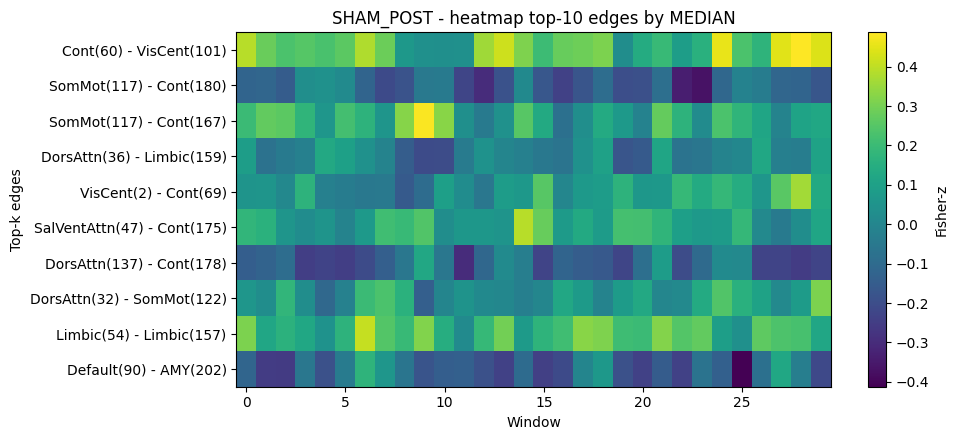

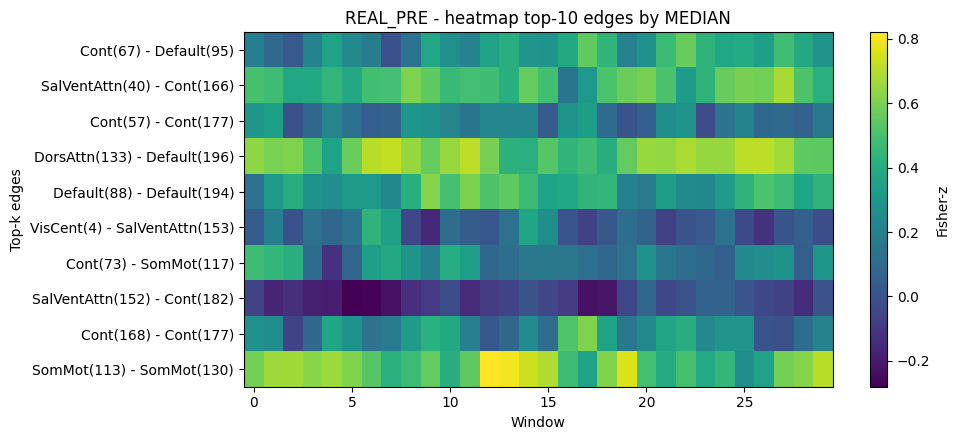

In [18]:
roi_roi_names = np.array([
    np.array([" - ".join((f'{netA}({i})', f'{netB}({j})')) for j, netB in enumerate(roi_to_network[combined_mask], start=1)
              ]) for i, netA in enumerate(roi_to_network[combined_mask], start=1)])
plot_topk_edge_heatmap(dfc_by_condition, cond='SHAM_PRE', metric='median',
                       roi_roi_names=vec_upper(roi_roi_names), k=10)
plot_topk_edge_heatmap(dfc_by_condition, cond='SHAM_POST', metric='median',
                       roi_roi_names=vec_upper(roi_roi_names), k=10)
plot_topk_edge_heatmap(dfc_by_condition, cond='REAL_PRE', metric='median',
                       roi_roi_names=vec_upper(roi_roi_names), k=10)
plot_topk_edge_heatmap(dfc_by_condition, cond='REAL_POST', metric='median',
                       roi_roi_names=vec_upper(roi_roi_names), k=10)

In [19]:
# 2.a) Build edge mask by pair of networks
networks_pair_masks, pairs = build_edge_masks_by_netpair(roi_net_masks, net_mask_names)
# 2.b) Metric per subject for each pair of networks 
if work_with_nets:
    base = np.zeros(effective_ROIs,dtype=np.bool)
    net1_net1 = np.zeros_like(base)
    net1_net1[:effective_ROIs-2] = True
    net1_net2 = np.ones_like(base)
    net2_net2 = np.zeros_like(base)
    net2_net2[effective_ROIs-2:] = True
    networks_pair_masks = {
        f'{which_networks[0]}-{which_networks[0]}':net1_net1,
        f'{which_networks[0]}-{which_networks[1]}':net1_net2,
        f'{which_networks[1]}-{which_networks[1]}':net2_net2
    }
    pairs = list(networks_pair_masks.keys())
series_by_cs_pair, df_metrics = netpair_metrics_per_subject(dfc_by_condition, roi_net_masks=None, net_mask_names=None, 
                                                            masks=networks_pair_masks)

df_metrics

condition  subj net_pair        mu        sd       vol     slope
0       SHAM_PRE     1  AMY-AMY  0.993827  0.405615  0.313538  0.016272
1       SHAM_PRE     2  AMY-AMY  0.901124  0.421598  0.277233  0.004118
2       SHAM_PRE     3  AMY-AMY  1.214000  0.502687  0.177725  0.021359
3       SHAM_PRE     4  AMY-AMY  1.260350  0.405873  0.272916  0.018958
4       SHAM_PRE     5  AMY-AMY  1.172030  0.540204  0.411150  0.008253
...          ...   ...      ...       ...       ...       ...       ...
10399  REAL_POST    13  pTH-pTH  0.698650  0.398385  0.308499  0.004645
10400  REAL_POST    14  pTH-pTH  0.298458  0.321195  0.234361 -0.013860
10401  REAL_POST    15  pTH-pTH  0.596396  0.398669  0.190204  0.018420
10402  REAL_POST    16  pTH-pTH  0.503173  0.419329  0.242709  0.000718
10403  REAL_POST    17  pTH-pTH  0.448386  0.434613  0.235839  0.010738

[10404 rows x 7 columns]

In [20]:
# df_metrics[np.logical_and(df_metrics['subj'] == 1, df_metrics['condition'] == 'SHAM_PRE')]

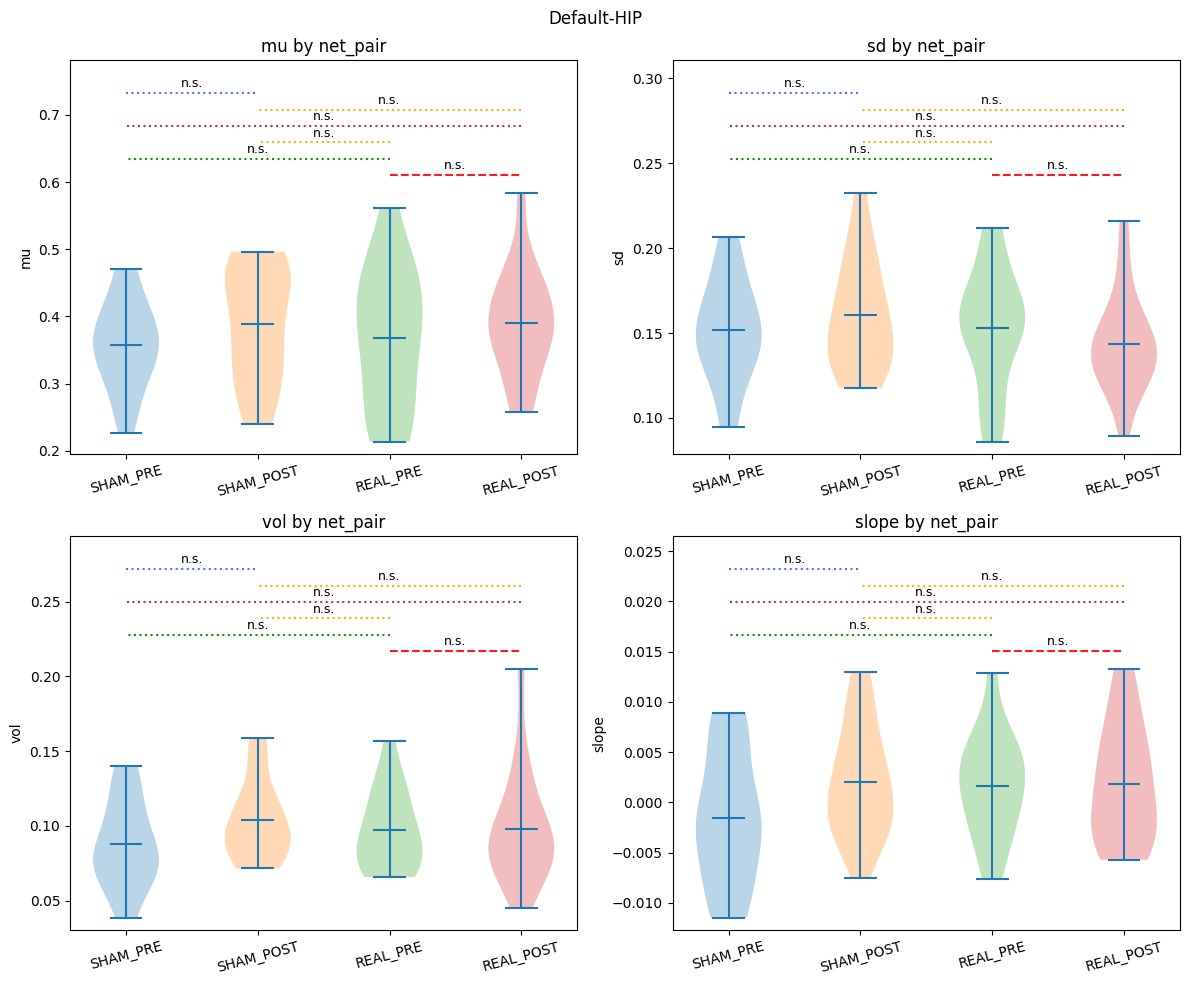

In [21]:
conds_all = ["REAL_PRE","REAL_POST","SHAM_PRE","SHAM_POST"]
compare_pairs_all = list(combinations(conds_all, 2))
paired_pairs_only_prepost = [("REAL_PRE","REAL_POST"), ("SHAM_PRE","SHAM_POST")]

connector_kwargs={
        ("REAL_PRE","REAL_POST"): {"ls":"--", "lw":1.5, "color":"red",      "alpha":0.9},
        ("REAL_PRE","SHAM_PRE"):  {"ls":":",  "lw":1.5, "color":"green",    "alpha":0.9},
        ("REAL_PRE","SHAM_POST"): {"ls":":",  "lw":1.5, "color":"orange",   "alpha":0.9},
        ("REAL_POST","SHAM_PRE"): {"ls":":",  "lw":1.5, "color":"brown",    "alpha":0.9},
        ("REAL_POST","SHAM_POST"): {"ls":":", "lw":1.5, "color":"orange",   "alpha":0.9},
        ("SHAM_PRE","SHAM_POST"): {"ls":":",  "lw":1.5, "color":"royalblue","alpha":0.9},
    }


fig, axarr = plt.subplots(2, 2, figsize=(12, 10))
plot_violin_metric_by_netpair(df_metrics, metric="mu", compare_pairs=compare_pairs_all, paired_pairs=paired_pairs_only_prepost,
                              netpairs=['-'.join(which_networks)], ax_array=axarr[0, 0], fdr=True, connector_kwargs=connector_kwargs)
plot_violin_metric_by_netpair(df_metrics, metric="sd", compare_pairs=compare_pairs_all, paired_pairs=paired_pairs_only_prepost, 
                              netpairs=['-'.join(which_networks)], ax_array=axarr[0, 1], fdr=True, connector_kwargs=connector_kwargs)
plot_violin_metric_by_netpair(df_metrics, metric="vol", compare_pairs=compare_pairs_all, paired_pairs=paired_pairs_only_prepost, 
                              netpairs=['-'.join(which_networks)], ax_array=axarr[1, 0], fdr=True, connector_kwargs=connector_kwargs)
plot_violin_metric_by_netpair(df_metrics, metric="slope", compare_pairs=compare_pairs_all, paired_pairs=paired_pairs_only_prepost, 
                              netpairs=['-'.join(which_networks)], ax_array=axarr[1, 1], fdr=True, connector_kwargs=connector_kwargs)
plt.suptitle(f"{'-'.join(which_networks)}")
plt.tight_layout()
plt.show()

In [22]:
df_global

condition  subj        mu        sd       vol     slope
0    SHAM_PRE     1  0.311561  0.149980  0.103119 -0.000719
1    SHAM_PRE     2  0.099256  0.048181  0.025550  0.001077
2    SHAM_PRE     3  0.126228  0.074875  0.028312  0.004916
3    SHAM_PRE     4  0.160944  0.059575  0.032973 -0.003384
4    SHAM_PRE     5  0.123363  0.089920  0.034329 -0.001979
..        ...   ...       ...       ...       ...       ...
63  REAL_POST    13  0.220481  0.084512  0.062687  0.003433
64  REAL_POST    14  0.163475  0.072907  0.055015  0.002610
65  REAL_POST    15  0.255841  0.168752  0.066121  0.012812
66  REAL_POST    16  0.208489  0.086096  0.052281  0.003732
67  REAL_POST    17  0.052589  0.031850  0.025525 -0.000059

[68 rows x 6 columns]

In [23]:
# 3) Paired tests PRE vs POST (REAL & SHAM)
df_paired_real = paired_tests_on_global(df_global, "REAL_PRE", "REAL_POST", test="ttest")   # test="wilcox"
df_paired_sham = paired_tests_on_global(df_global, "SHAM_PRE", "SHAM_POST", test="ttest")   # test="wilcox"

In [24]:
df_paired_real

metric      stat         p     meanA     meanB      diff    sig
0  slope -1.852531  0.082488  0.000037  0.002235 -0.002197  False
1    vol  0.867624  0.398427  0.053468  0.046832  0.006637  False
2     mu  0.700818  0.493484  0.175127  0.159777  0.015351  False
3     sd  0.237096  0.815591  0.081551  0.078896  0.002655  False

In [25]:
df_paired_sham

metric      stat         p     meanA     meanB      diff    sig
0  slope -1.867938  0.080197 -0.000177  0.001915 -0.002092  False
1     sd  0.535671  0.599554  0.074658  0.067982  0.006676  False
2     mu -0.107199  0.915964  0.155713  0.158589 -0.002876  False
3    vol  0.033492  0.973697  0.042724  0.042434  0.000291  False

#### PRE e POST dello stesso soggetto non sono indipendenti (stessa persona, stesso cervello). Per questo si usa un modello “misto” (o, in versione semplice, un test appaiato sul delta). L’indipendenza c’è solo tra soggetti diversi (e tra gruppi SHAM/REAL, che sono tra-soggetti).

#### Quello che ti aspetti (“PRE simili tra gruppi e SHAM_POST simile ai PRE”) si traduce in: $\Delta SHAM \approx 0$ (placebo non cambia), vuoi verificare se $\Delta REAL \not\approx 0$ e soprattutto se $\Delta REAL$ è diverso da $\Delta SHAM$. L’interazione $TIME\times STIM$ testa esattamente $H_0: \Delta REAL = \Delta SHAM$.

In [26]:
# # 3) Mixed model REAL×TIME
# time_map = {"REAL_PRE":"PRE","REAL_POST":"POST","SHAM_PRE":"PRE","SHAM_POST":"POST"}
# stim_map = {"REAL_PRE":"REAL","REAL_POST":"REAL","SHAM_PRE":"SHAM","SHAM_POST":"SHAM"}
# df_long  = build_longform_for_mixed(df_global, time_map, stim_map)
# res_mu   = fit_mixed_interaction(df_long, "mu")
# res_mu.summary()    # look at TIME:POST:STIM:REAL for the interaction:
#                     # the POST-PRE change in REALs minus the POST-PRE change in SHAMs. 
#                     # This is exactly "the effect of the stimulation net of the changes already made in the control.

#### Coef = −0.035 → l’interazione è negativa: il cambiamento POST-PRE nei REAL è 0.035 unità più piccolo del cambiamento negli SHAM (per quella metrica).
#### Std Err = 0.035 → incertezza della stima.
#### z = −0.994 → statistica di Wald.
#### p = 0.320 → non significativo a 0.05.
#### CI 95% = [−0.105, 0.034] → comprende 0 → coerente con non significatività.

In [27]:
for x, y, z, w in zip(swc_sham_pre, swc_sham_post, swc_real_pre, swc_real_post):
    print(x.shape, y.shape, z.shape, w.shape)
    break

(30, 23220) (30, 23220) (30, 23220) (30, 23220)


In [28]:
# 2.a) Choose number of PCs to retain
all_for_fit = swc_sham_pre + swc_sham_post + swc_real_pre + swc_real_post
X = np.concatenate(all_for_fit, axis=0)
# all_for_fit = [x - vec_upper(np.array(static_FC['SHAM_PRE']).mean(axis=0)) for x in swc_sham_pre] + [x - vec_upper(np.array(static_FC['SHAM_POST']).mean(axis=0)) for x in swc_sham_post] +\
#     [x - vec_upper(np.array(static_FC['REAL_PRE']).mean(axis=0)) for x in swc_real_pre] + [x - vec_upper(np.array(static_FC['REAL_POST']).mean(axis=0)) for x in swc_real_post]
# X = np.concatenate(all_for_fit, axis=0)

fileName_PCA = f"meta/pca_sel-step_{step}-win_len_{win_len}-gauss_{'T' if use_gaussian else 'F'}-\
fischer_{'T' if fisher_z else 'F'}-zscore_{'T' if zscore else 'F'}-\
work_with_nets_{'T' if work_with_nets else 'F'}.pkl"

if os.path.exists(fileName_PCA):
    with open(fileName_PCA, 'rb') as f:
        pca_sel = pickle.load(f)
    print("Loading PCA from file...")
    plot_cumulative_variance(pca_sel['cumvar'], pca_sel['targets'], pca_sel['pca'], X)
else:
    pca_sel = choose_pca_components(
        X=X,
        var_targets=(0.95, 0.99, 0.995), 
        whiten=False, fast_pca=False,
        max_samples=30000, max_components=5000,
        center=True, randomized=True, random_state=0, 
        show_plot=True
    )
    with open(fileName_PCA, "wb") as f:
        pickle.dump(pca_sel, f)
    
print("Suggested PCs:", pca_sel["targets"])   # es. {0.95: 38, 0.99: 92}
pca_for_metric = pca_sel["pca"]

Loading PCA from file...


Suggested PCs: {0.95: 1114, 0.99: 1652, 0.995: 1803}


Loading K-means selection from file...


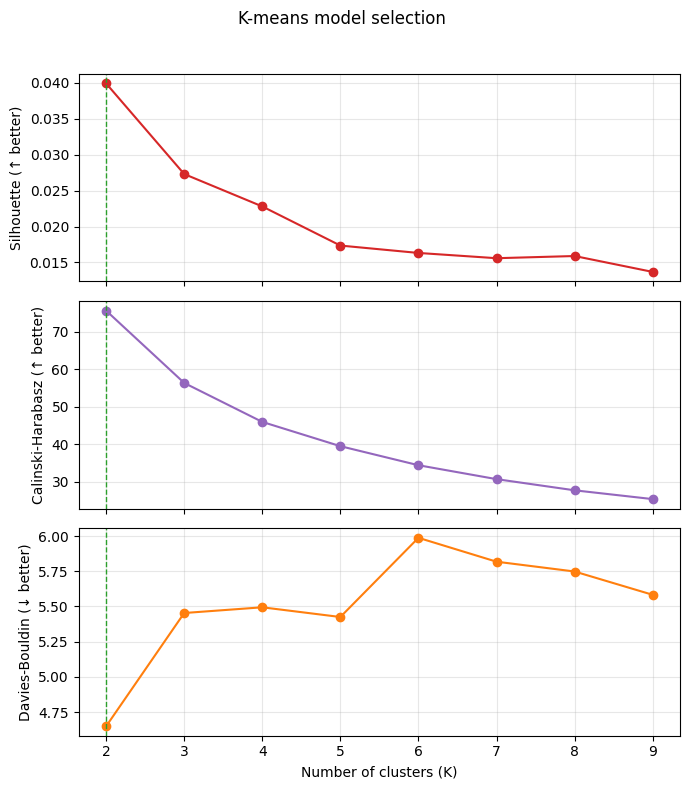

Best K by Silhouette: 2
Best K by Calinski-Harabasz: 2
Best K by Davies-Bouldin: 2


In [29]:
# 2.b) Choose K with K-means (k selection)
L1_norm_for_metric = False
fileName_kmeans = f"meta/k_sel-step_{step}-win_len_{win_len}-gauss_{'T' if use_gaussian else 'F'}-\
fischer_{'T' if fisher_z else 'F'}-zscore_{'T' if zscore else 'F'}-\
{'L1_norm_for_metric' if L1_norm_for_metric else 'PCA_for_metric'}-\
work_with_nets_{'T' if work_with_nets else 'F'}.pkl"

if os.path.exists(fileName_kmeans):
    with open(fileName_kmeans, 'rb') as f:
        k_sel = pickle.load(f)
    print("Loading K-means selection from file...")
    plot_k_selection(
        k_sel["Ks"], k_sel["sils"], k_sel["chs"], k_sel["dbs"], 
        k_sel["best_k_sil"], X, fast_k_means=False
    )
    plot_elbow(
        k_sel["Ks"], k_sel["inertias"], 
        best_k=k_sel["best_k_elbow"], logy=True
    )
else:
    k_sel = kmeans_k_selection(
        X=X,
        k_min=2, k_max=9,
        center=True,
        pca_for_metric=pca_for_metric,      # use the same PCA space to fit for Silhouette/CH/Davies–Bouldin
        L1_norm_for_metric=L1_norm_for_metric,
        static_FC=np.concatenate(list(static_FC.values()), axis=0),
        win_len_per_subj=(TimePoints-win_len)//step +1,
        sample_for_k=20000, ROIs=effective_ROIs,
        n_pcs=pca_sel["targets"][0.99],    # or 0.95, 0.99
        n_init=150, fast_k_means=False,
        random_state=0, show_plot=True
    )
    with open(fileName_kmeans, "wb") as f:
        pickle.dump(k_sel, f)

print("Best K by Silhouette:", k_sel["best_k_sil"])
print("Best K by Calinski-Harabasz:", k_sel["best_k_ch"])
print("Best K by Davies-Bouldin:", k_sel["best_k_db"])

In [30]:
# 3) Fit PCA+k-means on all dFC (concatenated over subjects and conditions)
fileName_kmeans_on_dfc = f"meta/fit_kmeans_on_dfc-step_{step}-win_len_{win_len}-gauss_{'T' if use_gaussian else 'F'}-\
fischer_{'T' if fisher_z else 'F'}-zscore_{'T' if zscore else 'F'}-\
{'L1_norm_for_metric' if L1_norm_for_metric else 'PCA_for_metric'}-\
work_with_nets_{'T' if work_with_nets else 'F'}.pkl"

k_number_of_states = min(k_sel['best_k_sil'], k_sel['best_k_ch'], k_sel['best_k_db'], k_sel['best_k_elbow'])
print(f'{k_number_of_states = }')

if os.path.exists(fileName_kmeans_on_dfc):
    with open(fileName_kmeans_on_dfc, 'rb') as f:
        k_on_dfc = pickle.load(f)
    pca, km, global_mean = k_on_dfc['pca'], k_on_dfc['km'], k_on_dfc['global_mean']
    print("Loading K-means selection from file...")
else:
    n_components = pca_sel['targets'][0.95]
    pca, km, global_mean = fit_kmeans_on_dfc(all_for_fit, 
                                            n_components=n_components, 
                                            k=k_number_of_states, 
                                            random_state=0)
    with open(fileName_kmeans_on_dfc, "wb") as f:
        pickle.dump({
            "pca":pca, 
            "km": km,
            "global_mean": global_mean
        }, f)

k_number_of_states = 2
Loading K-means selection from file...


In [31]:
# 4) Assign states and compute metrics for each condition
def metrics_for_condition(dfc_list, pca, km, global_mean):
    """
    dfc_list: list of dfc arrays (W,E) or (W,N,N) for all subjects in a condition
    Returns:
      occ_stack:   (n_subj, K)
      dwell_stack: (n_subj, K)
      trans_stack: (n_subj, K, K)
    """
    all_occ, all_dwell, all_run_lengths, all_trans_mats = [], [], [], []
    K = km.n_clusters # <- get K from the k-means model
    all_labels = []
    
    for dfc_vec in dfc_list:
        labels = predict_states(dfc_vec, pca, km, global_mean)
        all_labels.append(labels)
        occ, dwell, run_lengths, trans = state_metrics(labels, K=K)  # (K,), (K,), (K,K)
        all_occ.append(occ)
        all_dwell.append(dwell)
        all_run_lengths.append(run_lengths)
        all_trans_mats.append(trans)

    occ_stack   = np.vstack(all_occ)
    dwell_stack = np.vstack(all_dwell)
    trans_stack = np.stack(all_trans_mats, axis=0)
    all_labels  = np.vstack(all_labels)
    return occ_stack, dwell_stack, all_run_lengths, trans_stack, all_labels

In [32]:
occ_SHAM_PRE,   dwell_SHAM_PRE,  run_length_SHAM_PRE,  trans_SHAM_PRE,  labels_SHAM_PRE  = metrics_for_condition(swc_sham_pre, pca, km, global_mean)
occ_SHAM_POST,  dwell_SHAM_POST, run_length_SHAM_POST, trans_SHAM_POST, labels_SHAM_POST = metrics_for_condition(swc_sham_post, pca, km, global_mean)
occ_REAL_PRE,   dwell_REAL_PRE,  run_length_REAL_PRE,  trans_REAL_PRE,  labels_REAL_PRE  = metrics_for_condition(swc_real_pre, pca, km, global_mean)
occ_REAL_POST,  dwell_REAL_POST, run_length_REAL_POST, trans_REAL_POST, labels_REAL_POST = metrics_for_condition(swc_real_post, pca, km, global_mean)

In [33]:
# 5) Example of statistics: Mann-Whitney U test on occupancy of state 0
df_occ_REAL = compare_state_metrics(
    {"REAL_PRE": occ_REAL_PRE, "REAL_POST": occ_REAL_POST}, 
    "REAL_PRE", "REAL_POST",
    paired=True, test='ttest', alpha=0.05)
df_dwell_REAL = compare_state_metrics(
    {"REAL_PRE": dwell_REAL_PRE, "REAL_POST": dwell_REAL_POST}, 
    "REAL_PRE", "REAL_POST",
    paired=True, test='wilcoxon', alpha=0.05)

In [34]:
df_occ_REAL

state     meanA     meanB  diff_mean         t         p  effect_size  \
0      1  0.366667  0.258824   0.107843  1.459227  0.163856     0.353915   
1      0  0.633333  0.741176  -0.107843 -1.459227  0.163856    -0.353915   

          q    sig  
0  0.163856  False  
1  0.163856  False

In [35]:
df_dwell_REAL

state     meanA      meanB  diff_mean     W         p  effect_size  \
0      0  8.310784  10.805882  -2.495098  54.0  0.286760    -0.294118   
1      1  2.570728   1.982773   0.587955  55.0  0.308652    -0.281046   

          q    sig  
0  0.308652  False  
1  0.308652  False

In [36]:
df_occ_SHAM = compare_state_metrics(
    {"SHAM_PRE": occ_SHAM_PRE, "SHAM_POST": occ_SHAM_POST}, 
    "SHAM_PRE", "SHAM_POST",
    paired=True, test='ttest', alpha=0.05)
df_dwell_SHAM = compare_state_metrics(
    {"SHAM_PRE": dwell_SHAM_PRE, "SHAM_POST": dwell_SHAM_POST}, 
    "SHAM_PRE", "SHAM_POST",
    paired=True, test='wilcoxon', alpha=0.05)

In [37]:
df_occ_SHAM

state    meanA     meanB  diff_mean         t         p  effect_size  \
0      0  0.75098  0.723529   0.027451  0.267786  0.792285     0.064948   
1      1  0.24902  0.276471  -0.027451 -0.267786  0.792285    -0.064948   

          q    sig  
0  0.792285  False  
1  0.792285  False

In [38]:
df_dwell_SHAM

state      meanA     meanB  diff_mean     W         p  effect_size  \
0      1   2.323529  2.765686  -0.442157  59.0  0.641493    -0.132353   
1      0  11.399020  9.505882   1.893137  69.0  0.746658    -0.098039   

          q    sig  
0  0.746658  False  
1  0.746658  False

In [39]:
# 6) Example of statistics: compare delta occupancy REAL vs SHAM
df_occ_DELTA = compare_state_metrics(
    {"REAL": occ_REAL_PRE-occ_REAL_POST, "SHAM": occ_SHAM_PRE-occ_SHAM_POST}, 
    "REAL", "SHAM",
    paired=False, test='ttest', alpha=0.05)
df_dwell_DELTA = compare_state_metrics(
    {"REAL": dwell_REAL_PRE-dwell_REAL_POST, "SHAM": dwell_SHAM_PRE-dwell_SHAM_POST}, 
    "REAL", "SHAM",
    paired=False, test='wilcoxon', alpha=0.05)

In [40]:
df_occ_DELTA

state     meanA     meanB  diff_mean         t         p  effect_size  \
0      0 -0.107843  0.027451  -0.135294 -1.070588  0.293156    -0.358534   
1      1  0.107843 -0.027451   0.135294  1.070588  0.293156     0.358534   

          q    sig  
0  0.293156  False  
1  0.293156  False

In [41]:
df_dwell_DELTA

state     meanA     meanB  diff_mean         t         p  effect_size  \
0      0 -2.495098  1.893137  -4.388235 -0.986338  0.331416    -0.330320   
1      1  0.587955 -0.442157   1.030112  0.890589  0.382369     0.298254   

          q    sig  
0  0.382369  False  
1  0.382369  False

In [42]:
# ----- PLotting results -----
# 1) Centroids (needs your kmeans, pca, global_mean, and number of ROIs)
plot_state_centroids(km, pca, global_mean, n_rois=effective_ROIs, vmin=-1, vmax=1)

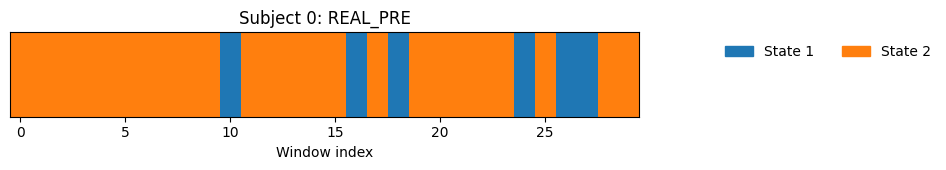

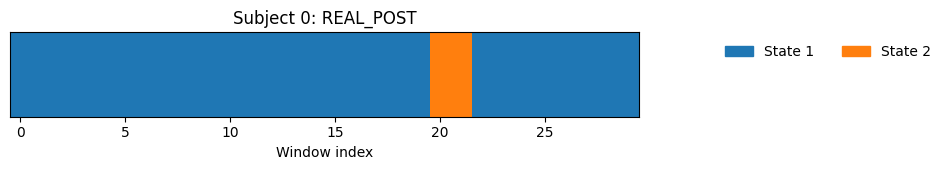

In [43]:
# 2) Barcode for one subject
subj_idx = 0
dfc_vec_pre = swc_real_pre[subj_idx]       # shape (W, E) for subject 0
labels_subject0_pre = predict_states(dfc_vec_pre, pca, km, global_mean)  # shape (W,)
plot_state_barcode(labels_subject0_pre, title="Subject 0: REAL_PRE")
dfc_vec_post = swc_real_post[subj_idx]       # shape (W, E) for subject 0
labels_subject0_post = predict_states(dfc_vec_post, pca, km, global_mean)  # shape (W,)
plot_state_barcode(labels_subject0_post, title="Subject 0: REAL_POST")
# barcode_plots(labels_subject0, title="State sequence (Subject 0, REAL_POST)")

In [44]:
order = ["SHAM_PRE","SHAM_POST","REAL_PRE","REAL_POST"]

In [45]:
# 3) Fractional occupancy (dict of condition -> (n_subj, K))
occ_dict = {"SHAM_PRE": occ_SHAM_PRE, "SHAM_POST": occ_SHAM_POST,
            "REAL_PRE": occ_REAL_PRE, "REAL_POST": occ_REAL_POST}
sig_df_map_occ = {
    ("REAL_PRE","REAL_POST"): df_occ_REAL,
    ("SHAM_PRE","SHAM_POST"): df_occ_SHAM,
}
plot_fractional_occupancy_boxplots(occ_dict, order=order, 
                                   sig_df=df_occ_REAL, alpha=0.05,
                                   cond_pairs=[("REAL_PRE","REAL_POST"), ("SHAM_PRE","SHAM_POST")],
                                   sig_df_map=sig_df_map_occ,
                                   connector_kwargs={
                                       ("REAL_PRE","REAL_POST"): {"linestyle":"--", "linewidth":1.5, "color":"k", "alpha":0.9},
                                       ("SHAM_PRE","SHAM_POST"): {"linestyle":":",  "linewidth":1.5, "color":"gray", "alpha":0.9},
                                       })

In [46]:
# alpha = 0.05
# K = next(iter(occ_dict.values())).shape[1]
# print((df_occ_REAL['q'] <= alpha).sum())  # quante righe significanti
# print(((df_occ_REAL['q'] <= alpha) & df_occ_REAL['state'].between(0, K-1)).sum())  # quante valide per il plo

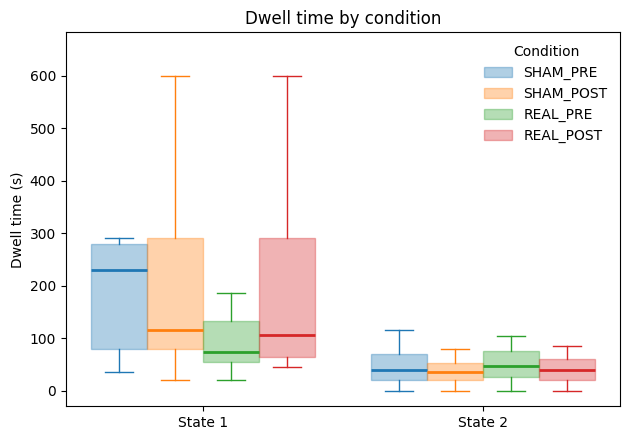

In [47]:
# 4) Dwell time
dwell_dict = {"SHAM_PRE": dwell_SHAM_PRE, "SHAM_POST": dwell_SHAM_POST,
              "REAL_PRE": dwell_REAL_PRE, "REAL_POST": dwell_REAL_POST}
sig_df_map_dwell = {
    ("REAL_PRE","REAL_POST"): df_dwell_REAL,
    ("SHAM_PRE","SHAM_POST"): df_dwell_SHAM,
}

dwell_dict_sec = {
    key: val* step * TR for key, val in dwell_dict.items()
    }
plot_dwell_time_boxplots(dwell_dict_sec, in_seconds=True, order=order, showfliers=False,  # or True if you've converted
                         cond_pairs=[("REAL_PRE","REAL_POST"), ("SHAM_PRE","SHAM_POST")],
                         sig_df_map=sig_df_map_dwell, alpha=0.05)

In [48]:
# # 5) Transition matrices
# trans_dict = {
#     "SHAM_PRE":     trans_SHAM_PRE,     # list of (K,K) per subject
#     "SHAM_POST":    trans_SHAM_POST,
#     "REAL_PRE":     trans_REAL_PRE,
#     "REAL_POST":    trans_REAL_POST,
# }
# plot_transition_matrices_by_condition(
#     trans_by_condition=trans_dict,
#     order=order,
#     colors=None,
#     cmap="viridis",
#     vmin=0.0, vmax=1.1,
#     annotate=False,
#     set_diag_zero=False,
#     suptitle="Average transition probabilities per condition"
# )

In [49]:
# # Or a single one:
# Tavg = average_transition_matrix(trans_SHAM_PRE)
# plot_transition_matrix(Tavg, cmap="magma", set_diag_zero=False, title="SHAM_PRE: average transitions")

In [50]:
# 6) Assign states and compute metrics for each subject, then save to file
def metrics_for_condition_full_save(dfc_list, pca, km, global_mean, step=step, TR=TR, file_name=None):
    """
    dfc_list: list of dfc arrays (W,E) or (W,N,N) for all subjects in a condition
    Returns:
      occ_stack:   (n_subj, K)
      dwell_stack: (n_subj, K)
      trans_stack: (n_subj, K, K)
    """
    K = km.n_clusters  # <- get K from the k-means model

    for kk, dfc_vec in enumerate(dfc_list):
        labels = predict_states(dfc_vec, pca, km, global_mean)
        out = state_metrics_full(labels, K=K, step=step, TR=TR)

        if file_name is not None:
            np.savez_compressed(
                f"{file_name}_subj{kk+1}.npz",
                occupancy=out["occupancy"],
                n_runs=out["n_runs"],
                mean_dwell=out["mean_dwell"],
                median_dwell=out["median_dwell"],
                trans_counts=out["trans_counts"],
                trans_matrix=out["trans_matrix"],
                dwell_from_Pkk=out["dwell_from_Pkk"],
                run_lengths=np.array([np.array(rl, dtype=int) for rl in out["run_lengths"]], dtype=object)
            )

In [51]:
all_labels = np.concatenate([predict_states(dfc, pca, km, global_mean) for dfc in all_for_fit])
win_cond = np.concat([[ord]*arr[0].shape[0]*len(arr) for ord, arr in zip(order, [swc_sham_pre, swc_sham_post, swc_real_pre, swc_real_post])])

In [52]:
centroids_by_cond = centroid_per_condition_state(X_vec=X, labels=all_labels, cond_of_win=win_cond, K=k_number_of_states)

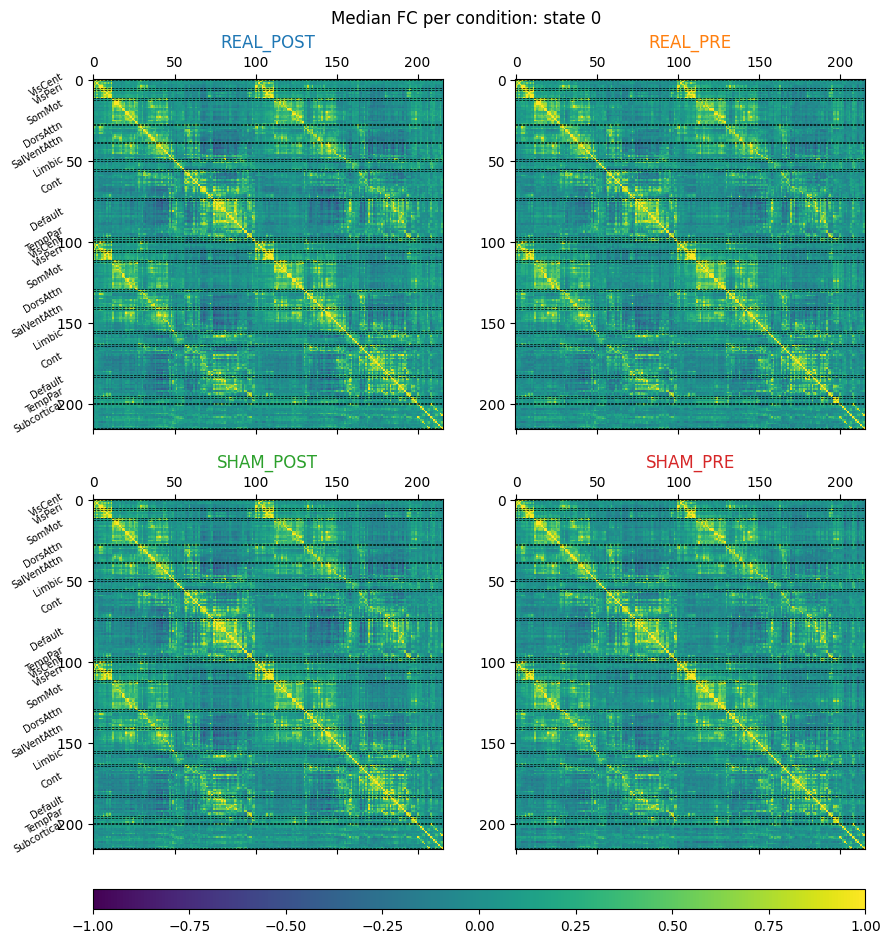

In [53]:
for state in range(k_number_of_states):
    plot_4_conditions({key: vec_to_matrix(val[state], N=effective_ROIs) for key, val in centroids_by_cond.items()},
                      roi_to_networks=roi_to_network[combined_mask], title=f'Median FC per condition: state {state}')

In [54]:
r_k_sham, l2_k_sham, zbar_sham, l2_mean_sham = centroid_similarity_stats(
    centroids_by_cond['SHAM_PRE'], 
    centroids_by_cond['SHAM_POST'], 
    K=k_number_of_states)
print('SHAM PRE vs POST:')
for k in range(k_number_of_states):
    print(f'State {k}:\nrbar = {r_k_sham[k]}\nl2 = {l2_k_sham[k]}')

r_k_real, l2_k_real, zbar_real, l2_mean_real = centroid_similarity_stats(
    centroids_by_cond['REAL_PRE'],
    centroids_by_cond['REAL_POST'], 
    K=k_number_of_states)
print('\nREAL PRE vs POST:')
for k in range(k_number_of_states):
    print(f'State {k}:\nrbar = {r_k_real[k]}\nl2 = {l2_k_real[k]}')

SHAM PRE vs POST:
State 0:
rbar = 0.9318545353244834
l2 = 11.866102526837466
State 1:
rbar = 0.8913426373980015
l2 = 16.27124237814744

REAL PRE vs POST:
State 0:
rbar = 0.9462211628904673
l2 = 10.570211758468192
State 1:
rbar = 0.9153571082013539
l2 = 14.584603181431453


In [55]:
# SHAM PRE vs POST
fileName_state_distance_SHAM = f"meta/state_distance-step_{step}-win_len_{win_len}-gauss_{'T' if use_gaussian else 'F'}-\
fischer_{'T' if fisher_z else 'F'}-zscore_{'T' if zscore else 'F'}-\
{'L1_norm_for_metric' if L1_norm_for_metric else 'PCA_for_metric'}-\
work_with_nets_{'T' if work_with_nets else 'F'}_SHAM_PRE_POST.pkl"
if os.path.exists(fileName_state_distance_SHAM):
    with open(fileName_state_distance_SHAM, 'rb') as f:
        d_SHAM = pickle.load(f)
    print("Loading from file...")

else:
    d_within_SHAM_PRE, d_within_SHAM_POST, d_SHAM_PRE_POST = [], [], []
    for k in range(k_number_of_states):
        d_within_SHAM_PRE_k, d_within_SHAM_POST_k, d_SHAM_PRE_POST_k, _, _ = state_distance_distributions(X_vec=X, labels=all_labels, cond_of_win=win_cond, 
                                                                                                          condA='SHAM_PRE', condB='SHAM_POST', 
                                                                                                          k=k, metric='euclidean')
        d_within_SHAM_PRE.append(d_within_SHAM_PRE_k)
        d_within_SHAM_POST.append(d_within_SHAM_POST_k)
        d_SHAM_PRE_POST.append(d_SHAM_PRE_POST_k)
    
    d_SHAM = {
        'SHAM_PRE':  {k:dis for k, dis in zip(range(k_number_of_states), d_within_SHAM_PRE)},
        'SHAM_POST': {k:dis for k, dis in zip(range(k_number_of_states), d_within_SHAM_POST)},
        'PRE-POST':  {k:dis for k, dis in zip(range(k_number_of_states), d_SHAM_PRE_POST)}
    }
    
    with open(fileName_state_distance_SHAM, "wb") as f:
        pickle.dump(d_SHAM, f)
 

p_value_SHAM = {
    f'State {k}':cohens_d(d_SHAM['SHAM_PRE'][k], d_SHAM['SHAM_POST'][k])\
        for k in range(k_number_of_states)
    }
print(f'{p_value_SHAM = }')

for k in range(k_number_of_states):
    plot_state_distance_distributions(d_SHAM['SHAM_PRE'][k], d_SHAM['SHAM_POST'][k], d_SHAM['PRE-POST'][k],
                                      labels=(f"Within SHAM_PRE", "Within SHAM_POST", "Cross PRE-POST"),
                                      title=f"Window-to-window distance distributions for one state {k+1}")

Loading from file...
p_value_SHAM = {'State 0': np.float64(-0.1957089986206809), 'State 1': np.float64(0.004978268615819399)}


Loading from file...
p_value_PRE = {'State 0': np.float64(-0.007247062941118714), 'State 1': np.float64(-0.06666334366572284)}


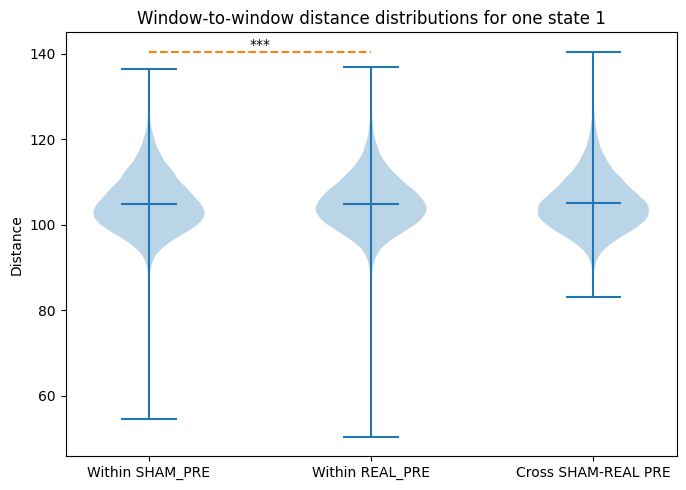

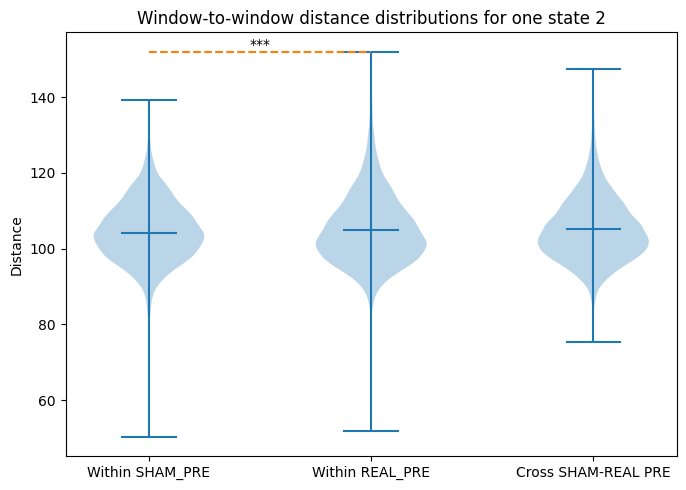

In [56]:
# Sham Pre vs Real PRE
fileName_state_distance_PRE = f"meta/state_distance-step_{step}-win_len_{win_len}-gauss_{'T' if use_gaussian else 'F'}-\
fischer_{'T' if fisher_z else 'F'}-zscore_{'T' if zscore else 'F'}-\
{'L1_norm_for_metric' if L1_norm_for_metric else 'PCA_for_metric'}-\
work_with_nets_{'T' if work_with_nets else 'F'}_SHAM_REAL_PRE.pkl"
if os.path.exists(fileName_state_distance_PRE):
    with open(fileName_state_distance_PRE, 'rb') as f:
        d_PRE = pickle.load(f)
    print("Loading from file...")

else:
    d_within_SHAM_PRE, d_within_REAL_PRE, d_SHAM_REAL_PRE = [], [], []
    for k in range(k_number_of_states):
        d_within_SHAM_PRE_k, d_within_REAL_PRE_k, d_SHAM_REAL_PRE_k, _, _ = state_distance_distributions(X_vec=X, labels=all_labels, cond_of_win=win_cond,
                                                                                                         condA='SHAM_PRE', condB='REAL_PRE', 
                                                                                                         k=k, metric='euclidean')
        d_within_SHAM_PRE.append(d_within_SHAM_PRE_k)
        d_within_REAL_PRE.append(d_within_REAL_PRE_k)
        d_SHAM_REAL_PRE.append(d_SHAM_REAL_PRE_k)
    
    d_PRE = {
        'SHAM_PRE': {k:dis for k, dis in zip(range(k_number_of_states), d_within_SHAM_PRE)},
        'REAL_PRE': {k:dis for k, dis in zip(range(k_number_of_states), d_within_REAL_PRE)},
        'PRE':      {k:dis for k, dis in zip(range(k_number_of_states), d_SHAM_REAL_PRE)}
    }
    
    with open(fileName_state_distance_PRE, "wb") as f:
        pickle.dump(d_PRE, f)
    
p_value_PRE = {
    f'State {k}':cohens_d(d_PRE['SHAM_PRE'][k], d_PRE['REAL_PRE'][k])\
        for k in range(k_number_of_states)
    }
print(f'{p_value_PRE = }')
    
for k in range(k_number_of_states):
    plot_state_distance_distributions(d_PRE['SHAM_PRE'][k], d_PRE['REAL_PRE'][k], d_PRE['PRE'][k],
                                      labels=(f"Within SHAM_PRE", "Within REAL_PRE", "Cross SHAM-REAL PRE"),
                                      title=f"Window-to-window distance distributions for one state {k+1}")

Loading from file...
p_value_REAL = {'State 0': np.float64(-0.007480507097692075), 'State 1': np.float64(0.05481212931979376)}


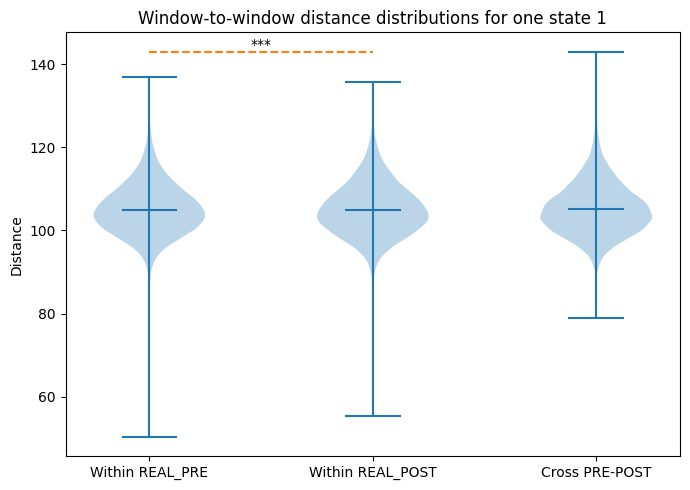

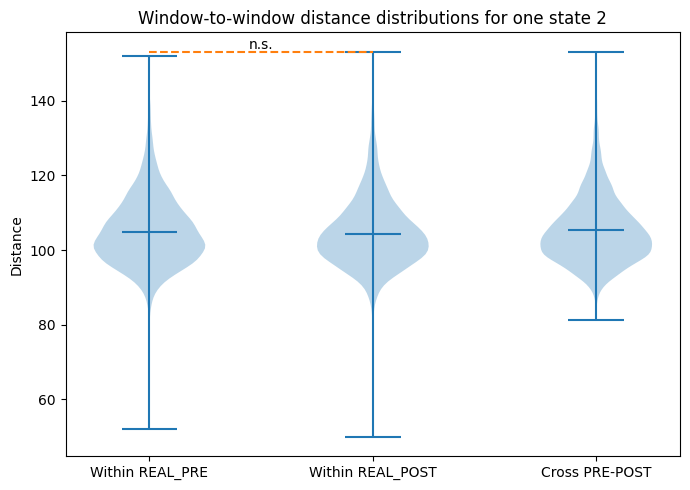

In [57]:
# Real Pre vs Real Post
fileName_state_distance_REAL = f"meta/state_distance-step_{step}-win_len_{win_len}-gauss_{'T' if use_gaussian else 'F'}-\
fischer_{'T' if fisher_z else 'F'}-zscore_{'T' if zscore else 'F'}-\
{'L1_norm_for_metric' if L1_norm_for_metric else 'PCA_for_metric'}-\
work_with_nets_{'T' if work_with_nets else 'F'}_REAL.pkl"
if os.path.exists(fileName_state_distance_REAL):
    with open(fileName_state_distance_REAL, 'rb') as f:
        d_REAL = pickle.load(f)
    print("Loading from file...")

else:
    d_within_REAL_PRE, d_within_REAL_POST, d_REAL_PRE_POST = [], [], []
    for k in range(k_number_of_states):
        d_within_REAL_PRE_k, d_within_REAL_POST_k, d_REAL_PRE_POST_k, _, _ = state_distance_distributions(X_vec=X, labels=all_labels, cond_of_win=win_cond,
                                                                                                          condA='REAL_PRE', condB='REAL_POST',
                                                                                                          k=k, metric='euclidean')
        d_within_REAL_PRE.append(d_within_REAL_PRE_k)
        d_within_REAL_POST.append(d_within_REAL_POST_k)
        d_REAL_PRE_POST.append(d_REAL_PRE_POST_k)
    
    d_REAL = {
        'REAL_PRE':  {k:dis for k, dis in zip(range(k_number_of_states), d_within_REAL_PRE)},
        'REAL_POST': {k:dis for k, dis in zip(range(k_number_of_states), d_within_REAL_POST)},
        'PRE-POST':  {k:dis for k, dis in zip(range(k_number_of_states), d_REAL_PRE_POST)}
    }
    
    with open(fileName_state_distance_REAL, "wb") as f:
        pickle.dump(d_REAL, f)
        
p_value_REAL = {
    f'State {k}':cohens_d(d_REAL['REAL_PRE'][k], d_REAL['REAL_POST'][k])\
        for k in range(k_number_of_states)
    }
print(f'{p_value_REAL = }')

for k in range(k_number_of_states):
    plot_state_distance_distributions(d_REAL['REAL_PRE'][k], d_REAL['REAL_POST'][k], d_REAL['PRE-POST'][k],
                                      labels=(f"Within REAL_PRE", "Within REAL_POST", "Cross PRE-POST"),
                                      title=f"Window-to-window distance distributions for one state {k+1}")